In [1]:
from simtk import openmm, unit
from pymbar import timeseries as ts
import numpy as np
import matplotlib.pyplot as plt
from time import time
from harmonic_mixture_sampler import strip_in_unit_system
%matplotlib inline

## Preliminary example of the OpenMM harmonic oscillator

The code developed here formed the basis of the `HarmonicSwapper` class in `harmonic_mixture_sampler.py`. The harmonic oscillator model used is based on https://github.com/choderalab/perses/blob/master/perses/tests/test_ncmc_integrator.py.

In the last cell, it's shown that about 100 to 200 steps of Langevin dynamics are sufficient to produce effectively uncorrelated samples of radii.

In [2]:
# Parameters for 3D harmonic oscillator
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
mass = 39.948 * unit.amu # mass of particle (argon)
sigma = 5.0 * unit.angstrom # standard deviation of harmonic oscillator
collision_rate = 5.0/unit.picosecond # collision rate
temperature = 300.0 * unit.kelvin # temperature
platform_name = 'CPU'


# Compute derived quantities.
kT = kB * temperature # thermal energy
beta = 1.0 / kT # inverse energy
K = kT / sigma**2 # spring constant
tau = 2 * np.pi * unit.sqrt(mass/K) # time constant
timestep = tau / 20.0
platform = openmm.Platform.getPlatformByName(platform_name)

def make_harmonic_context(K, positions = None, velocities = None):
    # Create the system and harmonic force
    system = openmm.System()
    system.addParticle(mass)
    energy_expression = '(K/2.0) * (x^2 + y^2 + z^2);'
    force = openmm.CustomExternalForce(energy_expression)
    force.addGlobalParameter('K', K.in_unit_system(unit.md_unit_system))
    force.addParticle(0, [])
    system.addForce(force)

    # Create the integrator and context
    integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
    platform = openmm.Platform.getPlatformByName(platform_name)
    context = openmm.Context(system, integrator, platform)
    
    # Set the positions and velocities.
    if positions is None:
        positions = unit.Quantity(np.zeros([1, 3], np.float32), unit.angstroms)
    context.setPositions(positions)
    if velocities is None:
        context.setVelocitiesToTemperature(temperature)
    else:
        context.setVelocities(velocities)
    return context, integrator, system    
    
    
    
# Create a 3D harmonic oscillator with context parameter controlling force constant
system = openmm.System()
system.addParticle(mass)
energy_expression = '(K/2.0) * (x^2 + y^2 + z^2);'
force = openmm.CustomExternalForce(energy_expression)
force.addGlobalParameter('K', K.in_unit_system(unit.md_unit_system))
force.addParticle(0, [])
system.addForce(force)

# Create the integrator and context
integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
platform = openmm.Platform.getPlatformByName(platform_name)
context = openmm.Context(system, integrator, platform)

 # Set the positions at the origin.
positions = unit.Quantity(np.zeros([1, 3], np.float32), unit.angstroms)
context.setPositions(positions)
context.setVelocitiesToTemperature(temperature)

### What number of steps produces effectively uncorrlated samples?
MD steps of 100 to 200 are sufficient to produce effectively uncorrelated samples of the harmonic oscillator radius.

Mean radius = 1.03954088688 Angstroms
Variance =  0.178979
Statisitcal inefficieny = 1.000000


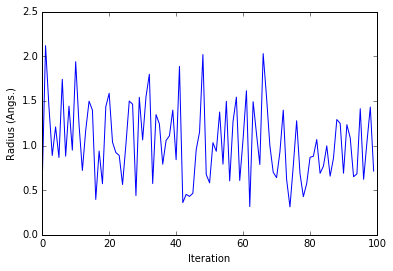

In [3]:
iterations = 100
radii = np.zeros(iterations,dtype=np.float32)

for i in range(iterations):
    integrator.step(150)
    pos = context.getState(getPositions=True).getPositions(asNumpy=True)
    pos = strip_in_unit_system(pos)[0]
    radii[i] = np.sqrt(np.sum(pos**2))

print 'Mean radius = {0} Angstroms'.format(np.mean(radii))
print 'Variance = ', np.var(radii)
print 'Statisitcal inefficieny = {:f}'.format(ts.statisticalInefficiency(radii))

plt.plot(radii)
plt.xlabel('Iteration')
plt.ylabel('Radius (Angs.)')
plt.show()